In [1]:
% matplotlib notebook
import json
from utils import *

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from scipy.signal import wiener

import math
import scipy

from kalman_filtering import oneIterPowerKalmanFilter

from indicator_simulation import *

/Users/stranot/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<IPython.core.display.Javascript object>


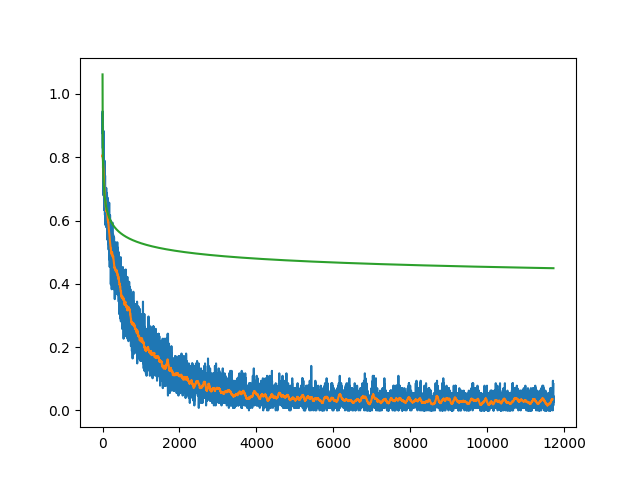

0.7577323173630898 -0.17629115177589014 0.304033730628428 0.0


/Users/stranot/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:40: RuntimeWarning: divide by zero encountered in log


In [253]:


data_file = 'jsons/val_err_wo_lr_decay.json'
# data_file = 'jsons/val_err.json'
# data_file = 'jsons/bs_32_val_err.json'
# data_file = 'jsons/imagenet_dataset0.json'
# data_file = 'jsons/cifar_all_lr_5e_2.json'
# data_file = 'jsons/cifar_all_lr_1e_1.json'
# data_file = 'jsons/cifar_all_lr_8e_2.json'

with open(data_file) as f:
    val_acc = json.load(f)

val_err = 1 - np.array(val_acc)
num_epochs_between_eval = 1
min_delta = 5e-4
patience = 10
steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval

smooth_win_size = 55
whole_smoothed_val_err = smooth_by_linear_filter(val_err, smooth_win_size)
plt.figure()
plt.plot((np.arange(len(val_err)) + 1)*num_epochs_between_eval, val_err)
plt.plot((np.arange(len(whole_smoothed_val_err)) + 1)*num_epochs_between_eval, whole_smoothed_val_err)

end = 150
real_steps = steps[:end]
real_val_err = val_err[:end]
bnds = ((0, None), (None, 0), (0,None), (0, None))
inits = (1,0,1,0)
fun = lambda x: np.sum(np.power((real_val_err-(np.exp(x[1]*np.log(real_steps)+np.log(x[0]))+np.exp(x[3]*np.log(real_steps)+np.log(x[2])))),2))
res = scipy.optimize.minimize(fun, inits, method='TNC', bounds=bnds)
a = res.x[0]
b = res.x[1]
c = res.x[2]
d = res.x[3]

plt.plot(steps, a*np.power(steps, b) + c*np.power(steps, d))
print(a,b,c,d)

500 5.959428167581102 2.531220950241808e-09
520 3.423844022547327 0.0006174204777718414
540 1.3645484721109733 0.17239500946708486
560 -0.20717293626372665 0.8358748025196799
580 -1.248271797260797 0.21193153870363624
600 -2.1435819532011022 0.03206639806763335
620 -3.9882659630171315 6.655802054384513e-05
640 -4.903691813202956 9.405201255213348e-07
660 -6.312738350847863 2.741407727120596e-10
680 -7.538990812710614 4.736223332855091e-14
700 -8.613932222403553 7.059643846062839e-18
720 -9.156663990814087 5.352642355725751e-20
740 -9.68160823105918 3.6099205616282464e-22
760 -9.811658338589163 1.0030636670151124e-22
780 -10.355594118720743 3.947282268003258e-25
800 -10.687195640390643 1.1685082023491292e-26
820 -10.80936750187971 3.1080559587736245e-27
840 -10.892424254558906 1.2526078762863918e-27
860 -11.548949823240568 7.4727952847098745e-31
880 -11.724623280833953 9.532415947865342e-32
900 -12.734964231937036 3.7801929688595154e-37
920 -12.980548147325596 1.5774755471042054e-38
940

<IPython.core.display.Javascript object>


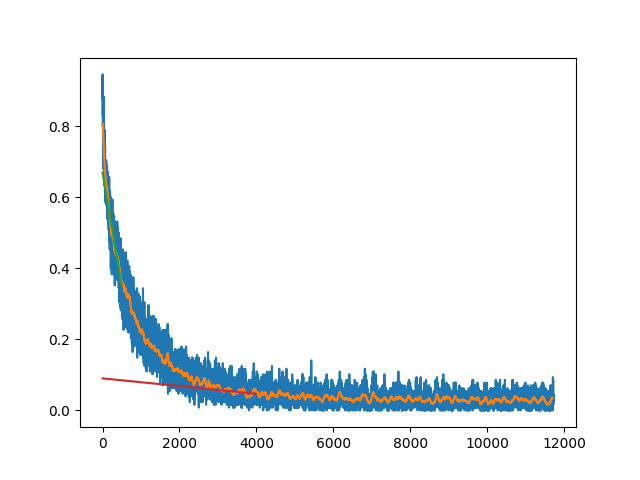

<IPython.core.display.Javascript object>


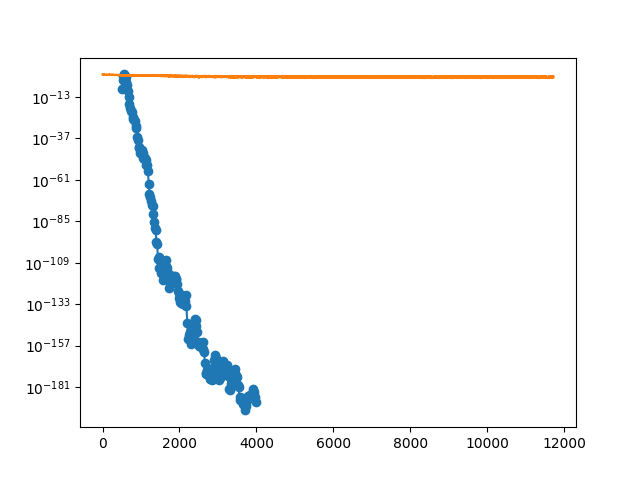

In [265]:
smoothed_steps = (np.arange(len(whole_smoothed_val_err)) + 1)*num_epochs_between_eval

start1 = 100
end1 = 500
start2 = start1
end2 = start2+50

zs = []
p_values = []
slope1, intercept1, r_value, p_value, std_err1 = \
                scipy.stats.linregress(smoothed_steps[start1:end1],val_err[start1:end1])
std_err1 = np.std(val_err[start1:end1] - slope1*smoothed_steps[start1:end1]+intercept1)/(np.sqrt(end1-start1) * np.std(smoothed_steps[start1:end1]))
for end2 in range(end1, 4000, 20):
#     end2 = start2 + 50
    start2 = end2 - 500
    slope2, intercept2, r_value, p_value, std_err2 = \
                    scipy.stats.linregress(smoothed_steps[start2:end2],val_err[start2:end2])
    numerator = slope1 - slope2
    
    std_err2 = np.std(val_err[start2:end2] - slope2*smoothed_steps[start2:end2]+intercept2)/(np.sqrt(end2-start2) * np.std(smoothed_steps[start2:end2]))
    denominator = pow((pow(std_err1,2) + pow(std_err2,2)), 1/2)
    z = numerator / denominator
    p_value = scipy.stats.norm.sf(abs(z))*2
    print(end2,z, p_value)
    
    zs.append(z)
    p_values.append(p_value)

plt.figure()
plt.plot((np.arange(len(val_err)) + 1)*num_epochs_between_eval, val_err)
plt.plot((np.arange(len(whole_smoothed_val_err)) + 1)*num_epochs_between_eval, whole_smoothed_val_err)
plt.plot(smoothed_steps[:end1], slope1*smoothed_steps[:end1]+intercept1)
plt.plot(smoothed_steps[:end2], slope2*smoothed_steps[:end2]+intercept2)
plt.figure()
plt.semilogy(num_epochs_between_eval*(np.arange(end1, 4000, 20)+1), p_values, '-o')



<IPython.core.display.Javascript object>


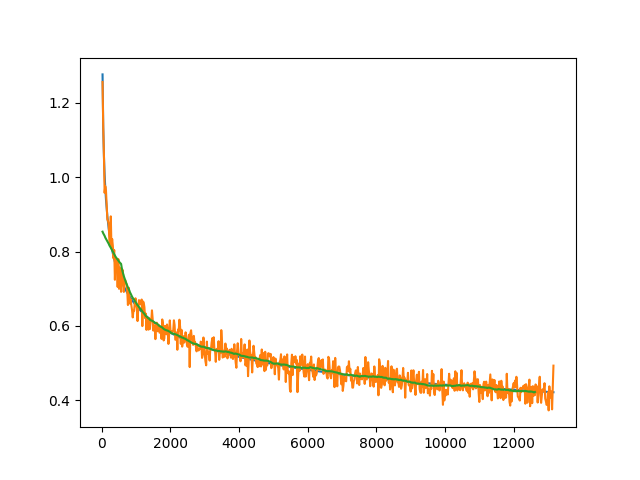

0.0004075434602200015


In [227]:
a = 2.1296990908675575
b = -0.17078869800251614
var = 0.00047153359673779487
steps = (np.arange(len(val_err)) + 1)*num_epochs_between_eval
y = a*np.power(steps,b)
noise = np.random.normal(0, np.sqrt(var), len(steps))
x = y + noise

smoothed_x = smooth_by_linear_filter(x, smooth_win_size)

plt.figure()
plt.plot(steps, y)
plt.plot(steps, x)
plt.plot(smoothed_steps, smoothed_x)

var_est = np.var(x[50:100]-smoothed_x[50:100])
print(var_est)
# plt.semilogx(steps, x)

<IPython.core.display.Javascript object>


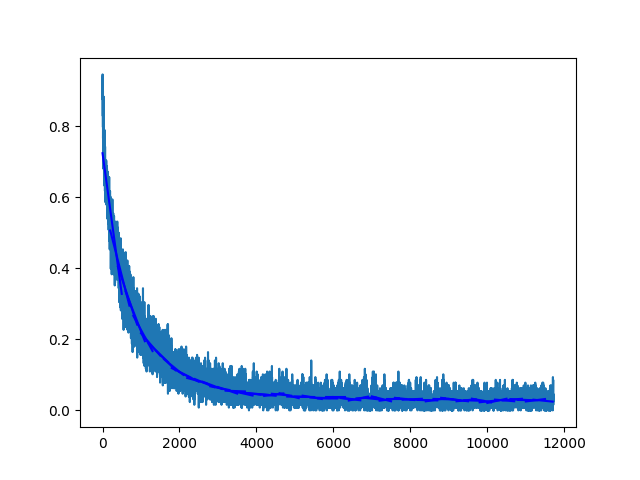

500 1.4454740318220698e-180
700 1.7113848415467227e-112
900 1.2815812052023012e-83
1100 7.204488276444126e-70
1300 1.0583442664473941e-47
1500 3.1071667254766215e-26
1700 9.527938972148377e-20
1900 4.703742954073297e-22
2100 2.1325517379307557e-17
2300 2.5547465629379687e-10
2500 1.2046075086570466e-10
2700 0.00012779656086102427
2900 5.2985460269955696e-09
3100 2.3237649851530819e-07
3300 0.0022482146630447186
3500 7.214442839698395e-08
3700 0.2731396694405056
3900 0.00015605308562428784
4100 0.02933434824404777
4300 0.09712652119714212
4500 0.0667445256294407
4700 0.9834998345785657
4900 0.04286686634503732
5100 1.9957273638130128e-06
5300 0.3416755781951321
5500 0.3203139565803812
5700 0.0006893116731630709
5900 0.28577594403124496
6100 0.46676432533074136
6300 0.4960913517006381
6500 0.015353973986528937
6700 0.008754887958197205
6900 0.9999315085164313
7100 0.7967916442445092
7300 0.03453318823891838
7500 1.606271277101085e-06
7700 0.9948395748224017
7900 0.5055807309495786
8100 0

<IPython.core.display.Javascript object>


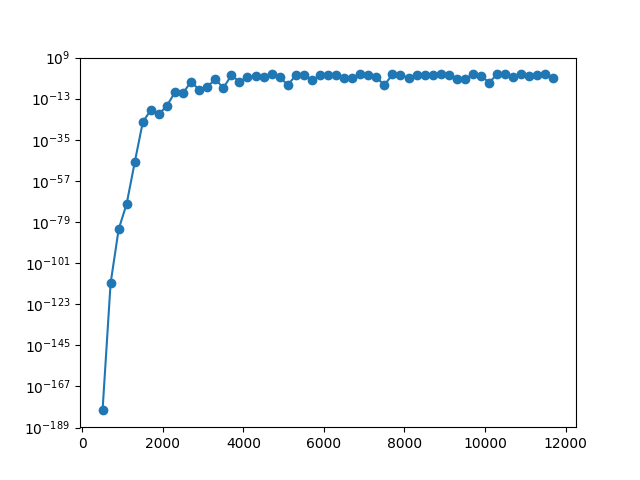

In [285]:
data_file = 'jsons/cifar_subset_train_summary_1.json'
with open(data_file) as f:
    dict_ = json.load(f)

# eval_err = dict_['eval_err']
# eval_epochs = dict_['eval_epochs']
err = np.array(dict_['train_err'])
steps = np.array(dict_['train_epochs'])

plt.figure()
plt.plot(steps, err)

num_points = 500
p_values = []
for end in range(500, len(steps), 200):
    start = end - num_points
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(steps[start:end],err[start:end])
#     t_value = scipy.stats.t.isf(p_value / 2, df=num_points-2)
    t_value = slope / std_err
    p_value = scipy.stats.t.cdf(t_value, df=num_points-2)
    plt.plot(steps[start:end], slope*steps[start:end]+intercept, 'b')
    p_values.append(p_value)

    print(end,p_value)
    
plt.figure()
plt.semilogy(range(500, len(steps), 200), p_values, '-o')